# Analytics

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Gabriel Alves Hussein 17/0103200
- Rafael Ribeiro de Oliveira 15/0045182
- Nícalo Ribeiro Dourado Araújo 16/0016169
- Murilo Loiola Dantas 17/0163571
- Maciel Ferreira Custódio Júnior 19/0100087
- Guilherme Aguera de la Fuente Vilela 19/0088168
- Carlos Eduardo Miranda Roriz 19/0011424
- Davi Lima da Silva 19/0026588
- Karla Chaiane da Silva Feliciano 20/0021541
- Endy Sally Soares Andrade 18/0113194

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
27,duplicated_lines_density,0.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
28,functions,14,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
29,security_rating,1.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
30,files,6,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
31,complexity,21,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
32,ncloc,150,NaN,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
33,coverage,86.2,False,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
34,reliability_rating,1.0,True,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
35,comment_lines_density,1.3,False,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
0,duplicated_lines_density,0.0,True,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,03-16-2022-06:44:01-v2.1.0


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [10]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['Cargos', 'Clients', 'Demands', 'Frontend', 'Sectors', 'Users'],
      dtype=object)

In [45]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,tests,test_errors,test_failures,test_execution_time,security_rating,reliability_rating,test_success_density,test,filename,repository,version
201,src/Utils/functionsJWT.js,2,4,0.0,0.0,0.0,16,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
202,src/index.js,3,3,0.0,0.0,94.4,28,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
203,src/Models/RoleSchema.js,0,0,0.0,0.0,100.0,20,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
204,src/Controllers/RolesController.js,8,11,3.1,0.0,91.9,62,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
205,src/routes.js,0,0,0.0,0.0,100.0,10,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
206,src/Utils/validate.js,1,3,0.0,0.0,71.4,14,NaN,NaN,NaN,1.555,1.0,1.0,100.0,1.0,fga-eps-mds_2021-2-SiGeD-Cargos-03-18-2022-21:...,Cargos,03-18-2022-21:27:05-v1.0.0
0,src/Services/Axios/baseService.js,0,0,0.0,0.0,100.0,8,NaN,NaN,NaN,2.563,1.0,1.0,100.0,2.0,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,03-16-2022-06:44:01-v2.1.0
1,src/Controllers/ClientController.js,10,22,0.4,0.0,71.9,230,NaN,NaN,NaN,2.563,5.0,1.0,100.0,2.0,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,03-16-2022-06:44:01-v2.1.0
2,src/Models/ClientSchema.js,0,0,0.0,0.0,100.0,84,NaN,NaN,NaN,2.563,1.0,1.0,100.0,2.0,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,03-16-2022-06:44:01-v2.1.0
3,src/Controllers/FeatureController.js,6,8,0.0,0.0,100.0,66,NaN,NaN,NaN,2.563,5.0,1.0,100.0,2.0,fga-eps-mds_2021-2-SiGeD-Clients-03-16-2022-06...,Clients,03-16-2022-06:44:01-v2.1.0


#### Create dataframe per repository

In [12]:
# Example

repo1_df = file_component_df[file_component_df['repository'] == 'Cargos']
repo2_df = file_component_df[file_component_df['repository'] == 'Clients']
repo3_df = file_component_df[file_component_df['repository'] == 'Demands']
repo4_df = file_component_df[file_component_df['repository'] == 'Frontend']
repo5_df = file_component_df[file_component_df['repository'] == 'Sectors']
repo6_df = file_component_df[file_component_df['repository'] == 'Users']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [16]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [17]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [18]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [19]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [20]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [21]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [22]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [23]:
repo1_metrics = create_metrics_df(repo1_df)
repo2_metrics = create_metrics_df(repo2_df)
repo3_metrics = create_metrics_df(repo3_df)
repo4_metrics = create_metrics_df(repo4_df)
repo5_metrics = create_metrics_df(repo5_df)
repo6_metrics = create_metrics_df(repo6_df)


### Data visualization

- You must do this for each of your repositories

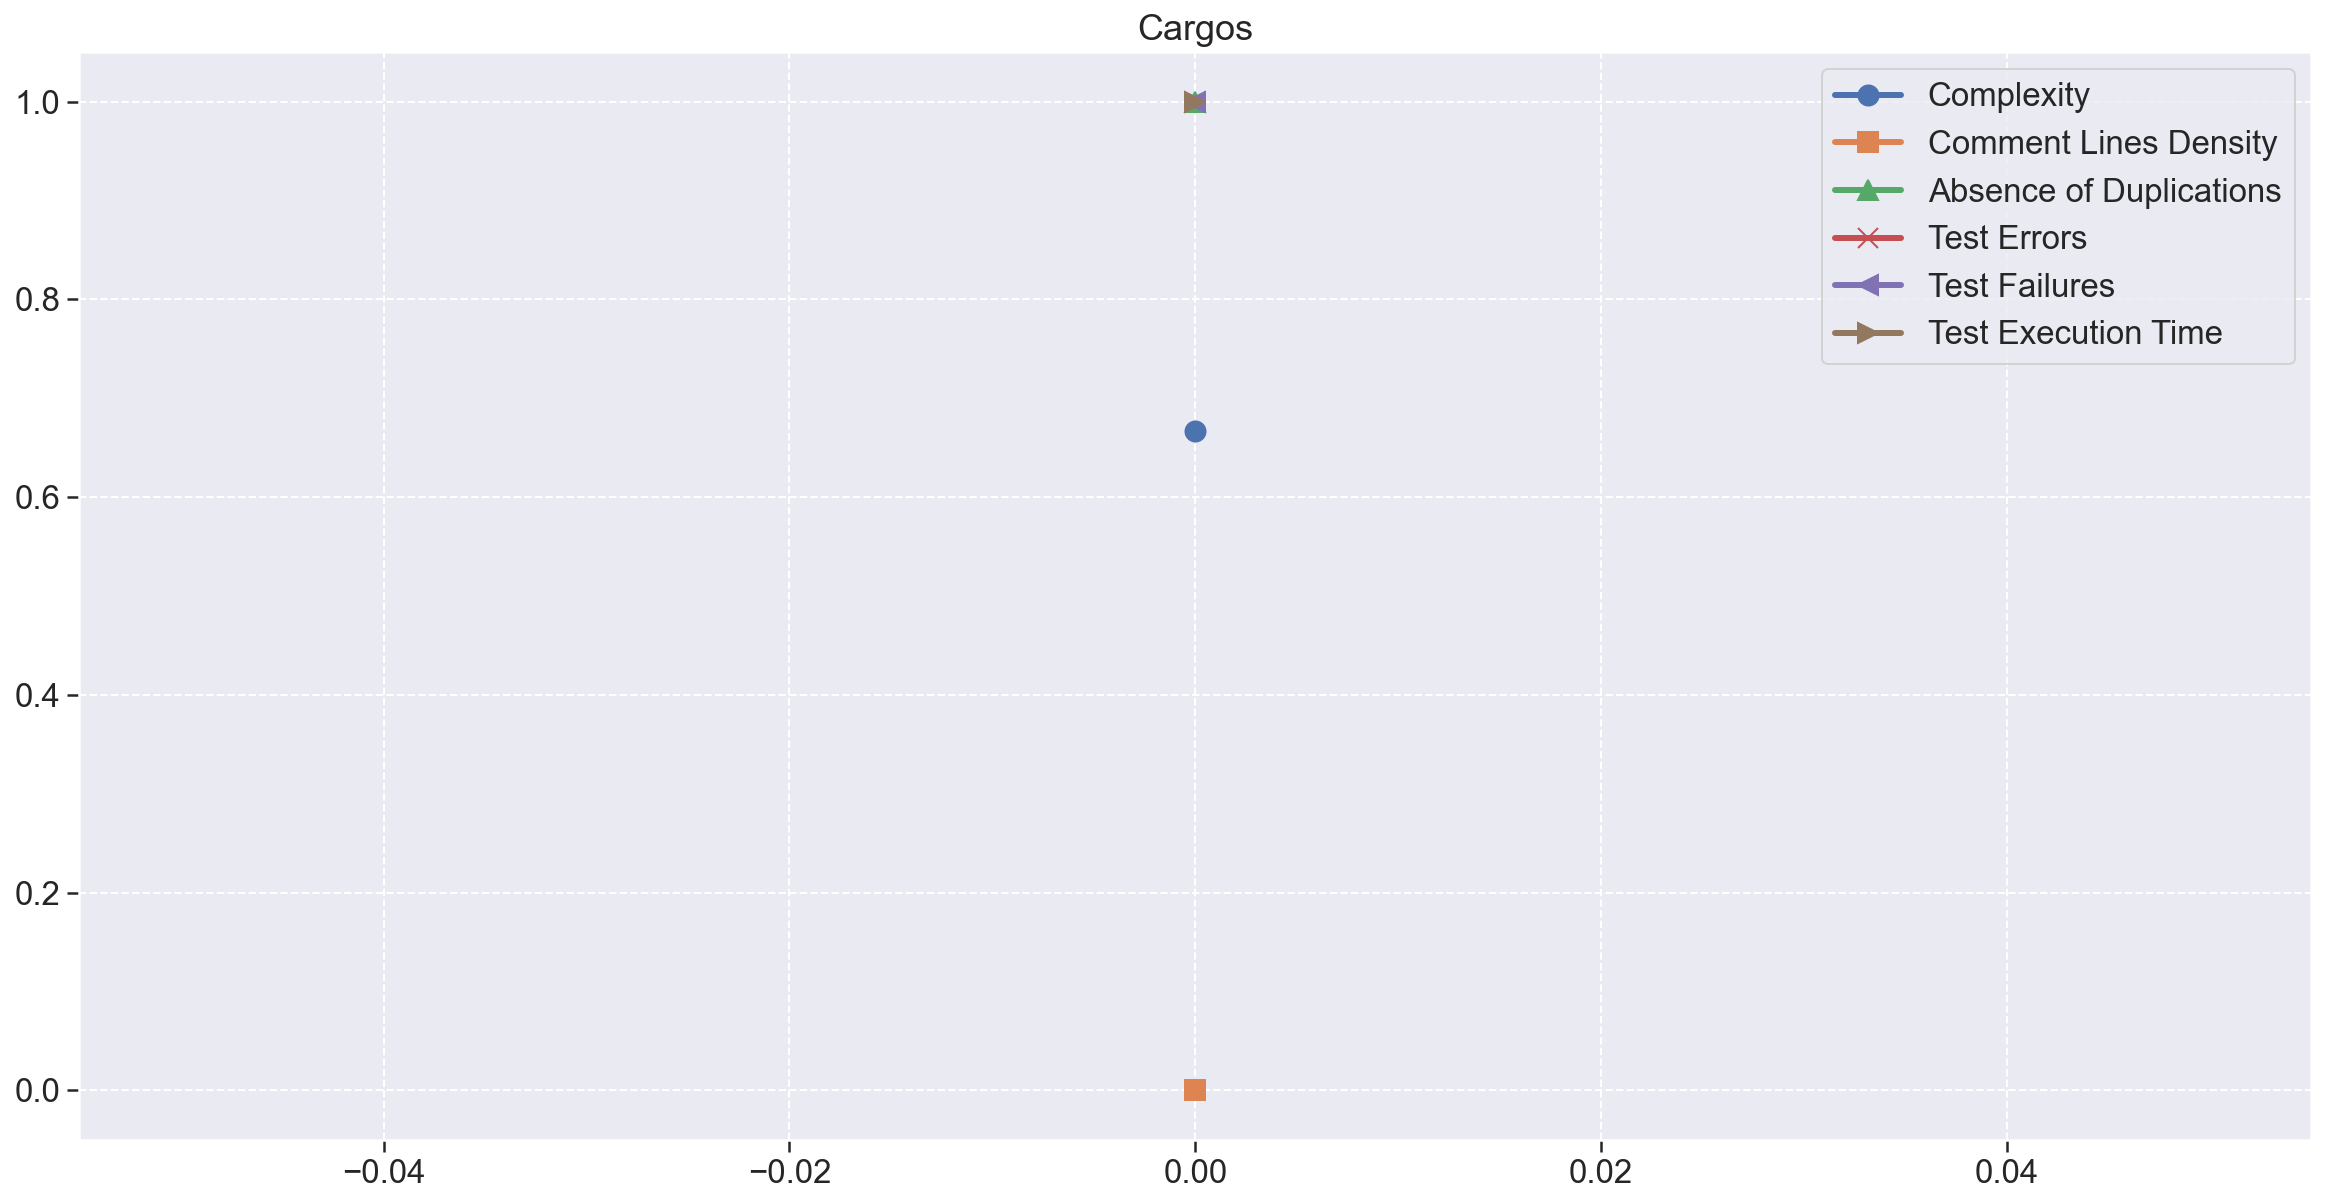

In [39]:
fig = plt.figure(figsize=(20, 10))

plt.title('Cargos')
plt.plot(repo1_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo1_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo1_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo1_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo1_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo1_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

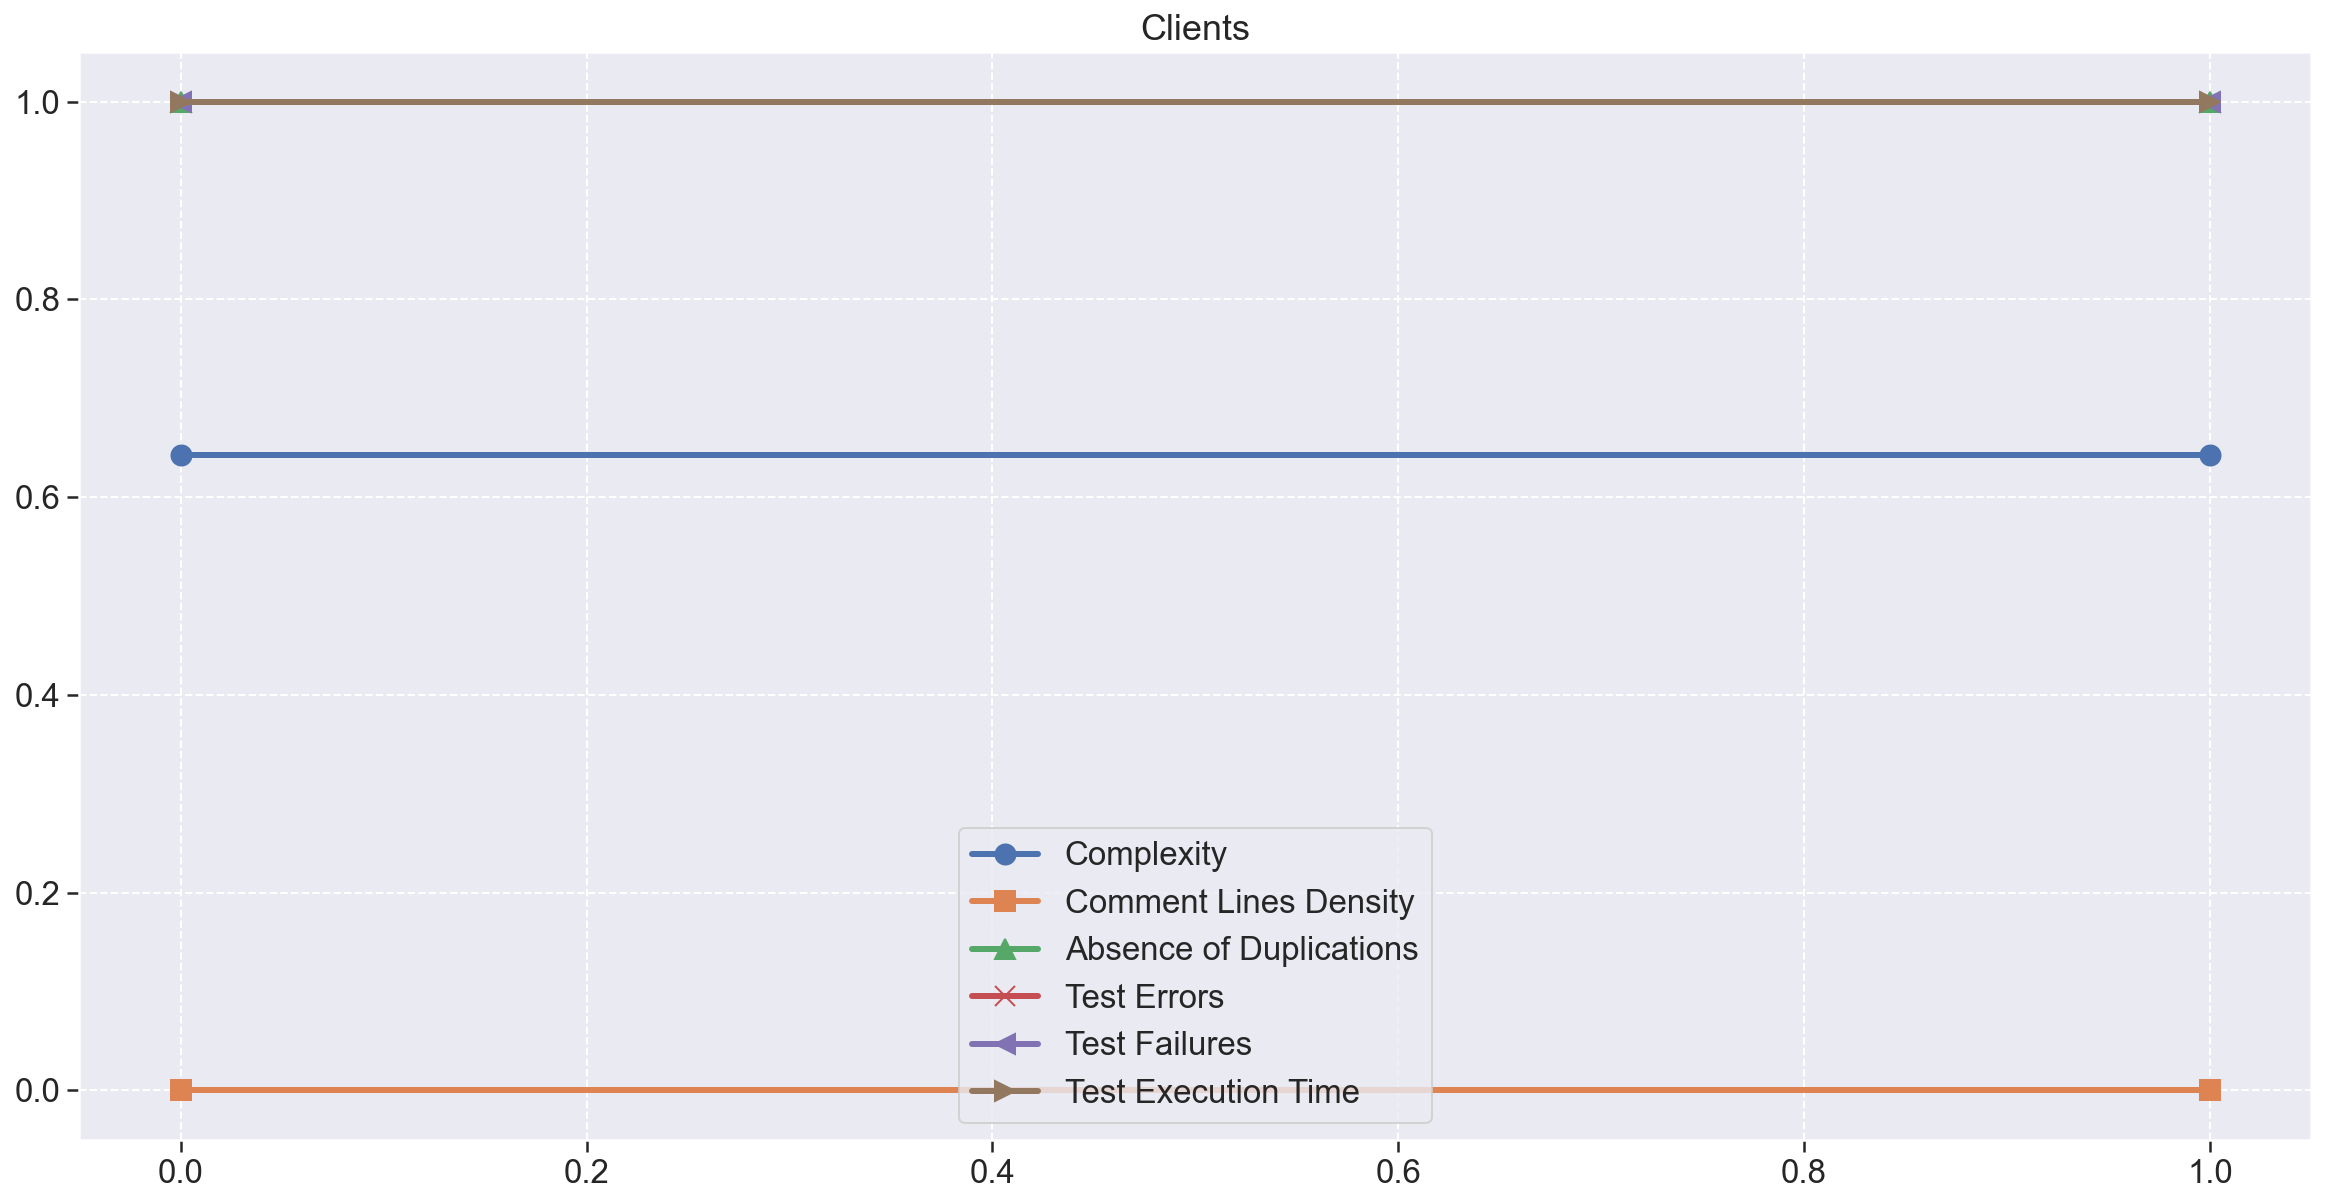

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.title('Clients')
plt.plot(repo2_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo2_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo2_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo2_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo2_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo2_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

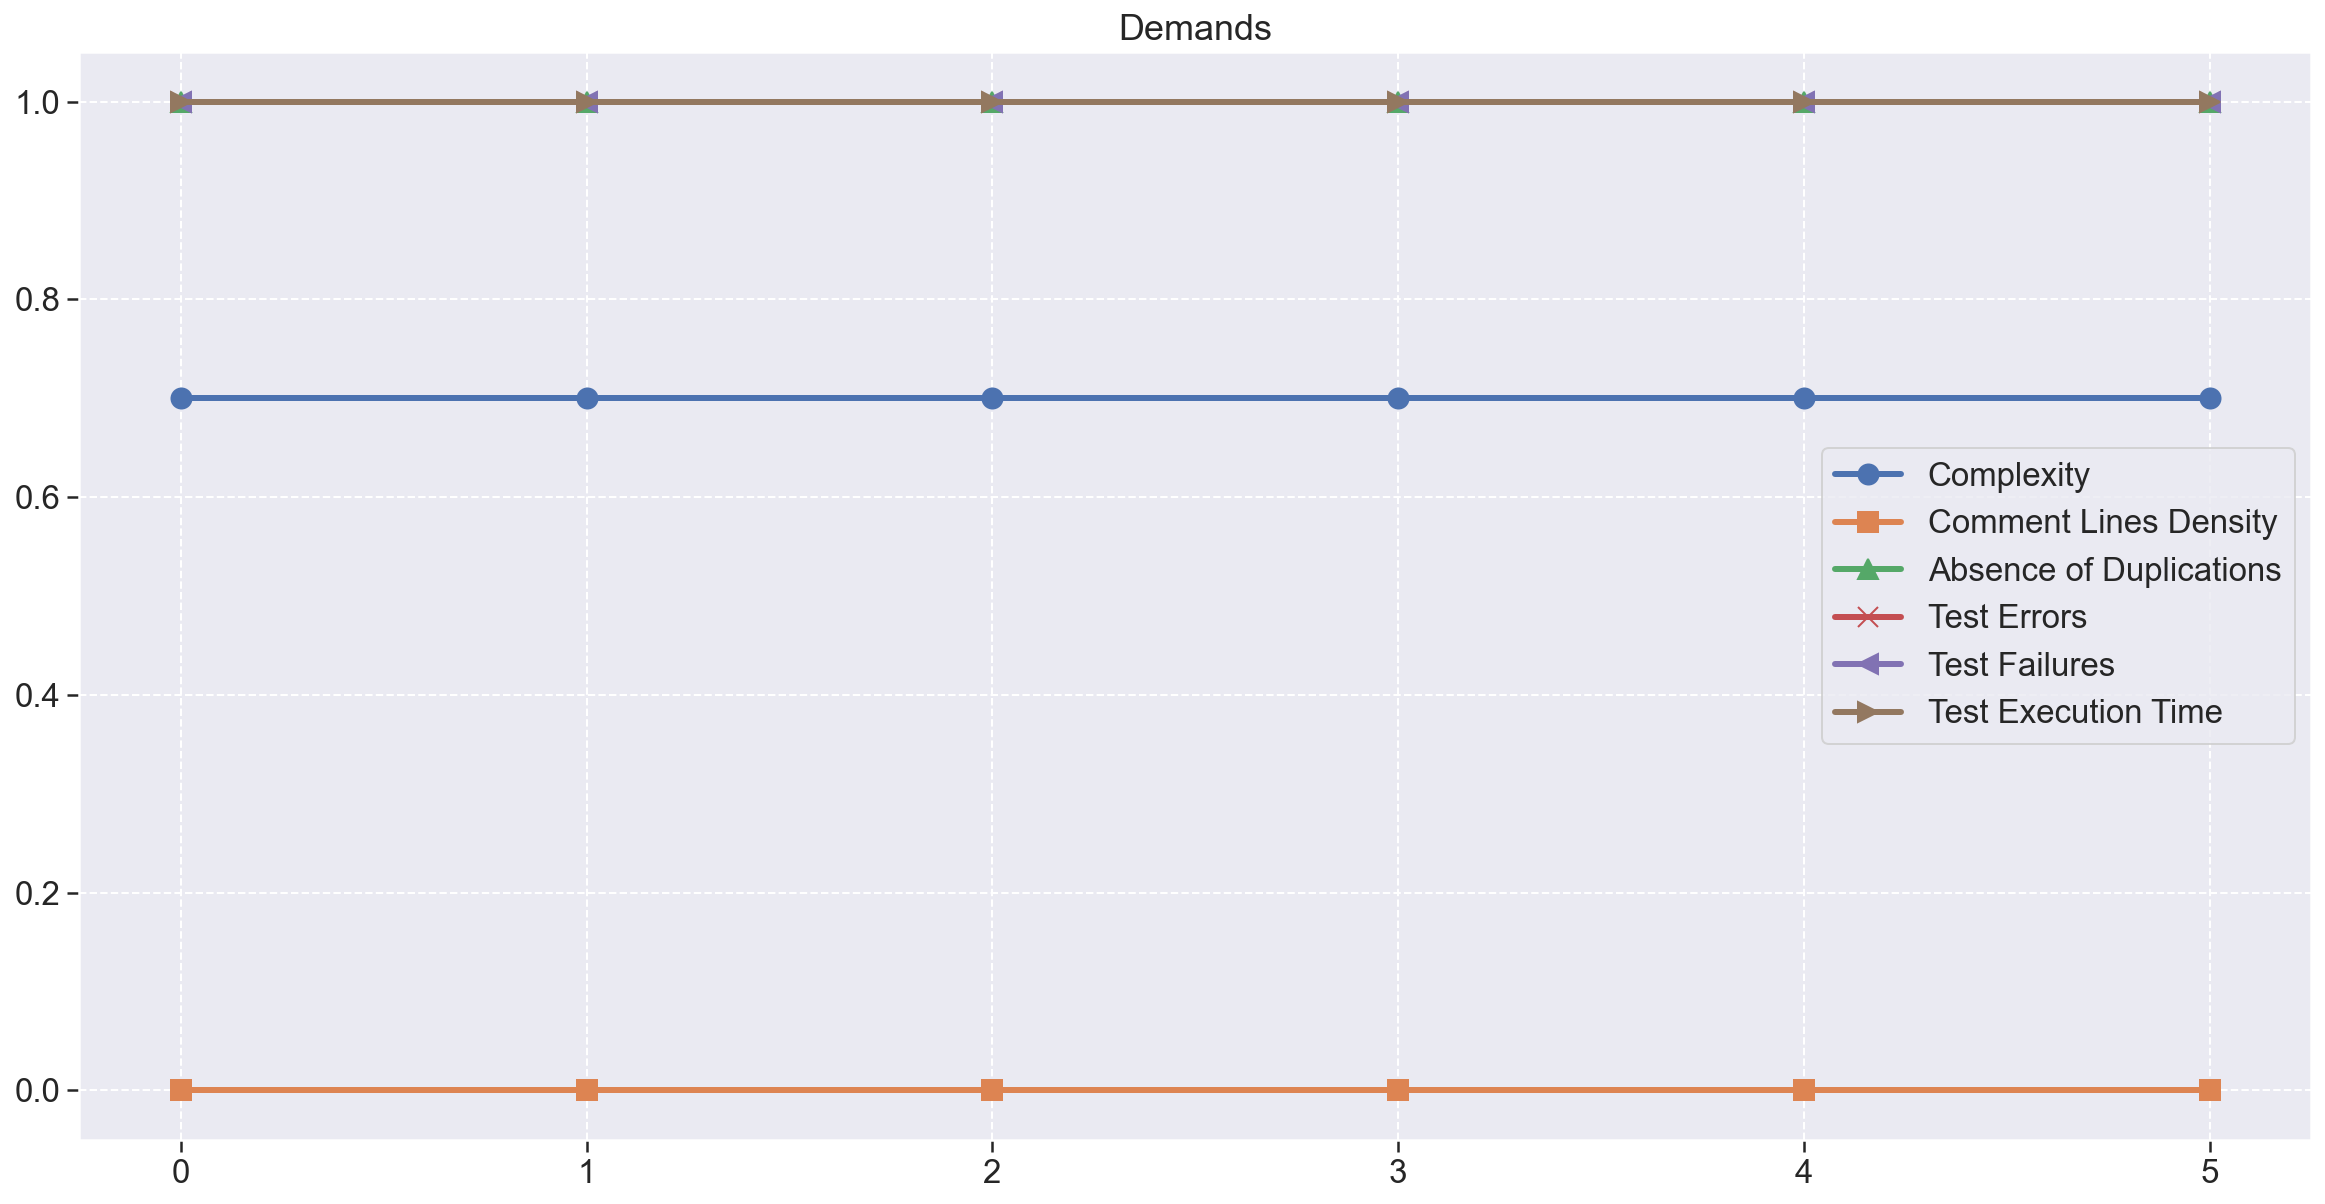

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.title('Demands')
plt.plot(repo3_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo3_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo3_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo3_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo3_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo3_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

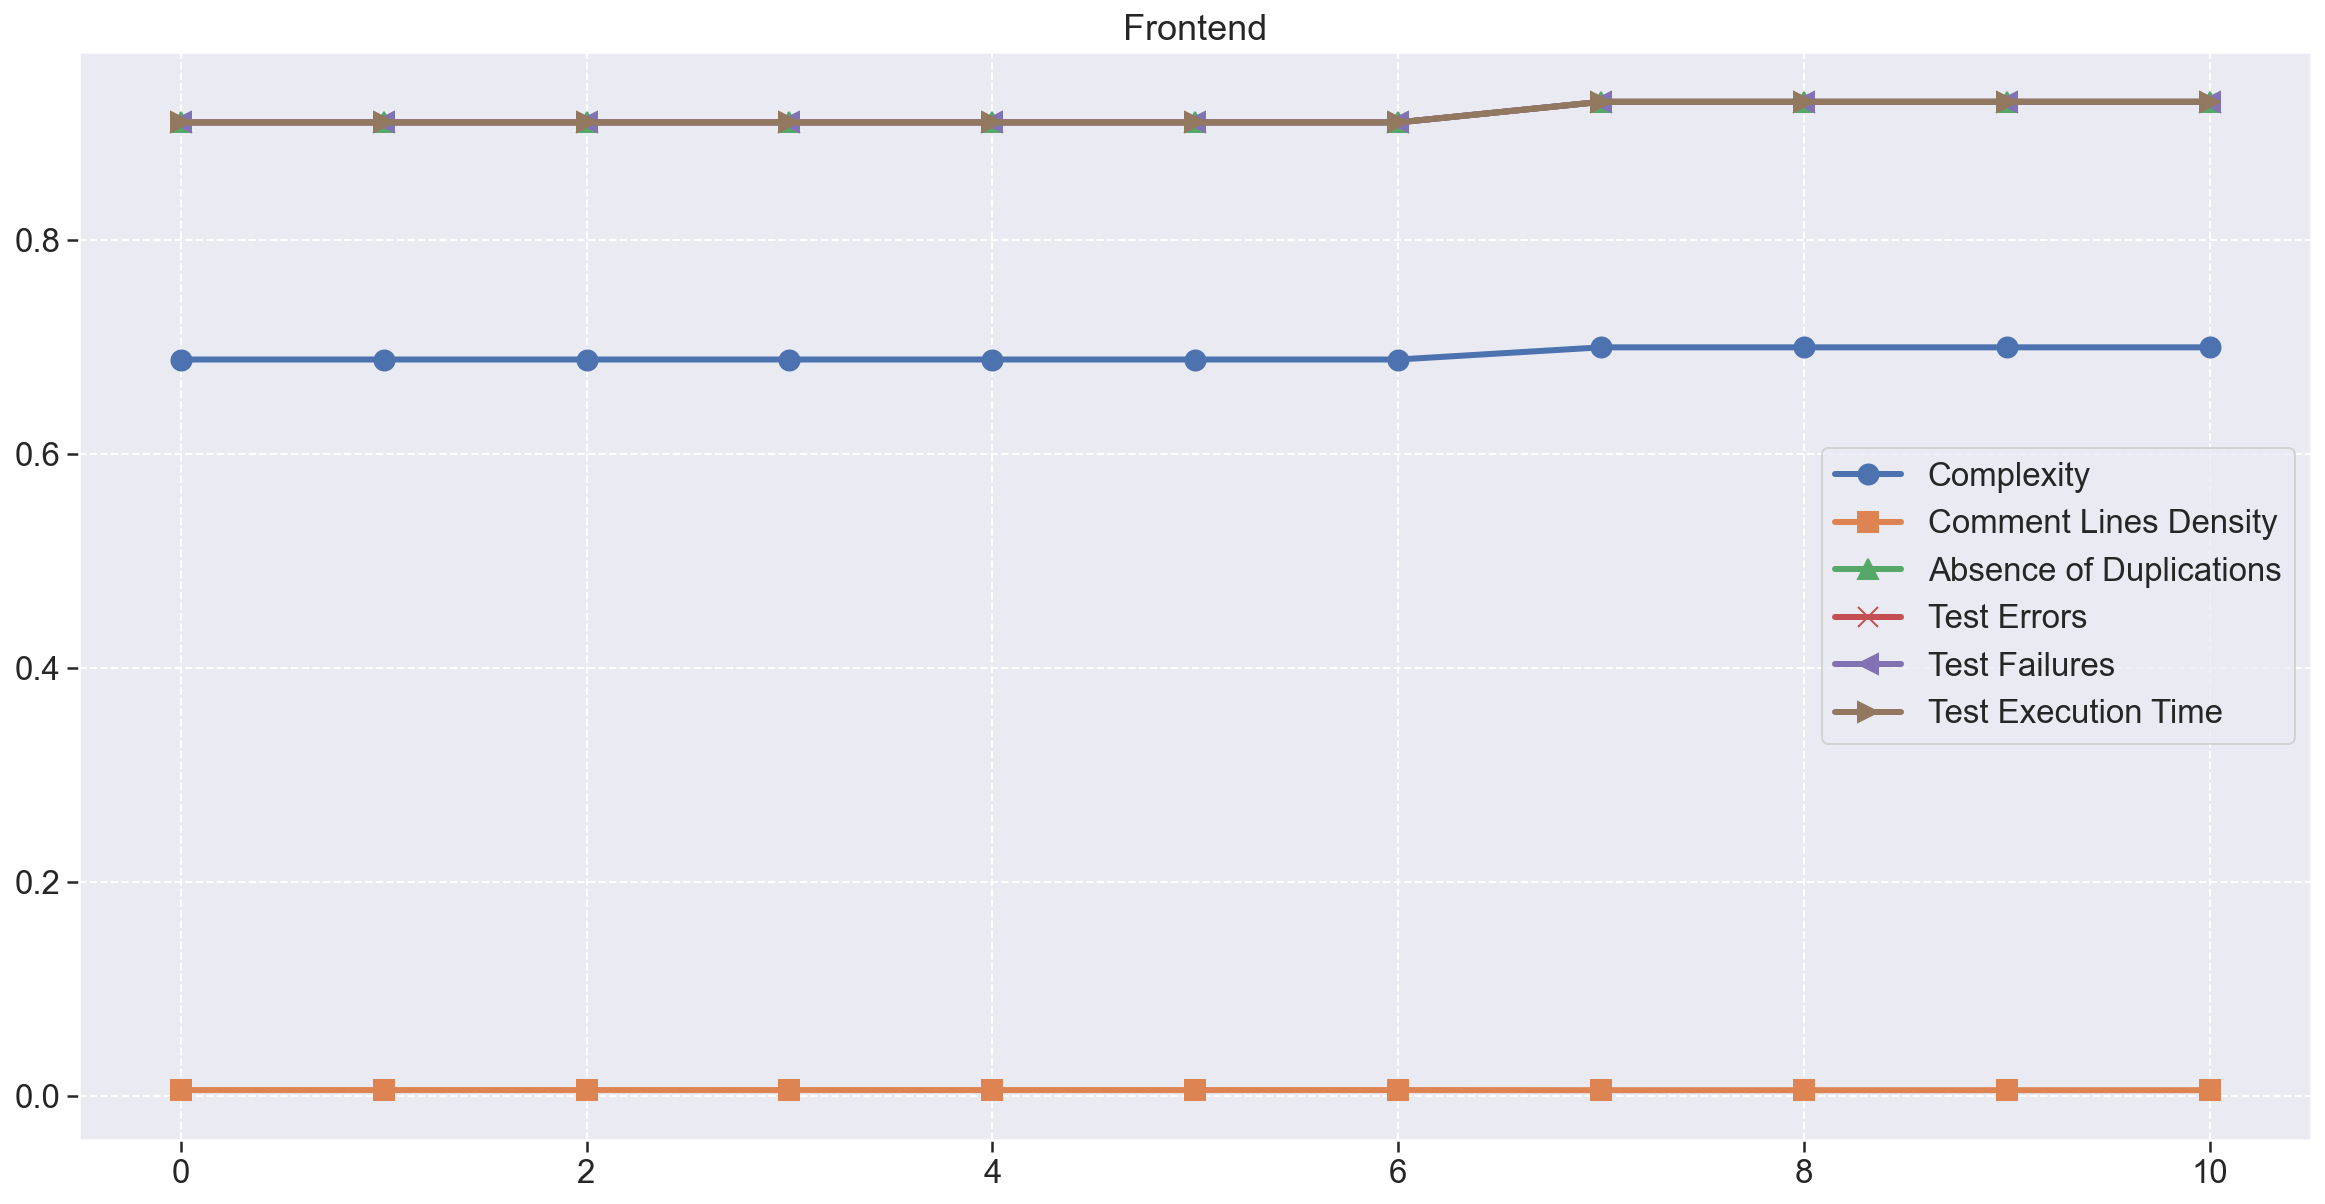

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.title('Frontend')
plt.plot(repo4_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo4_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo4_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo4_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo4_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo4_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

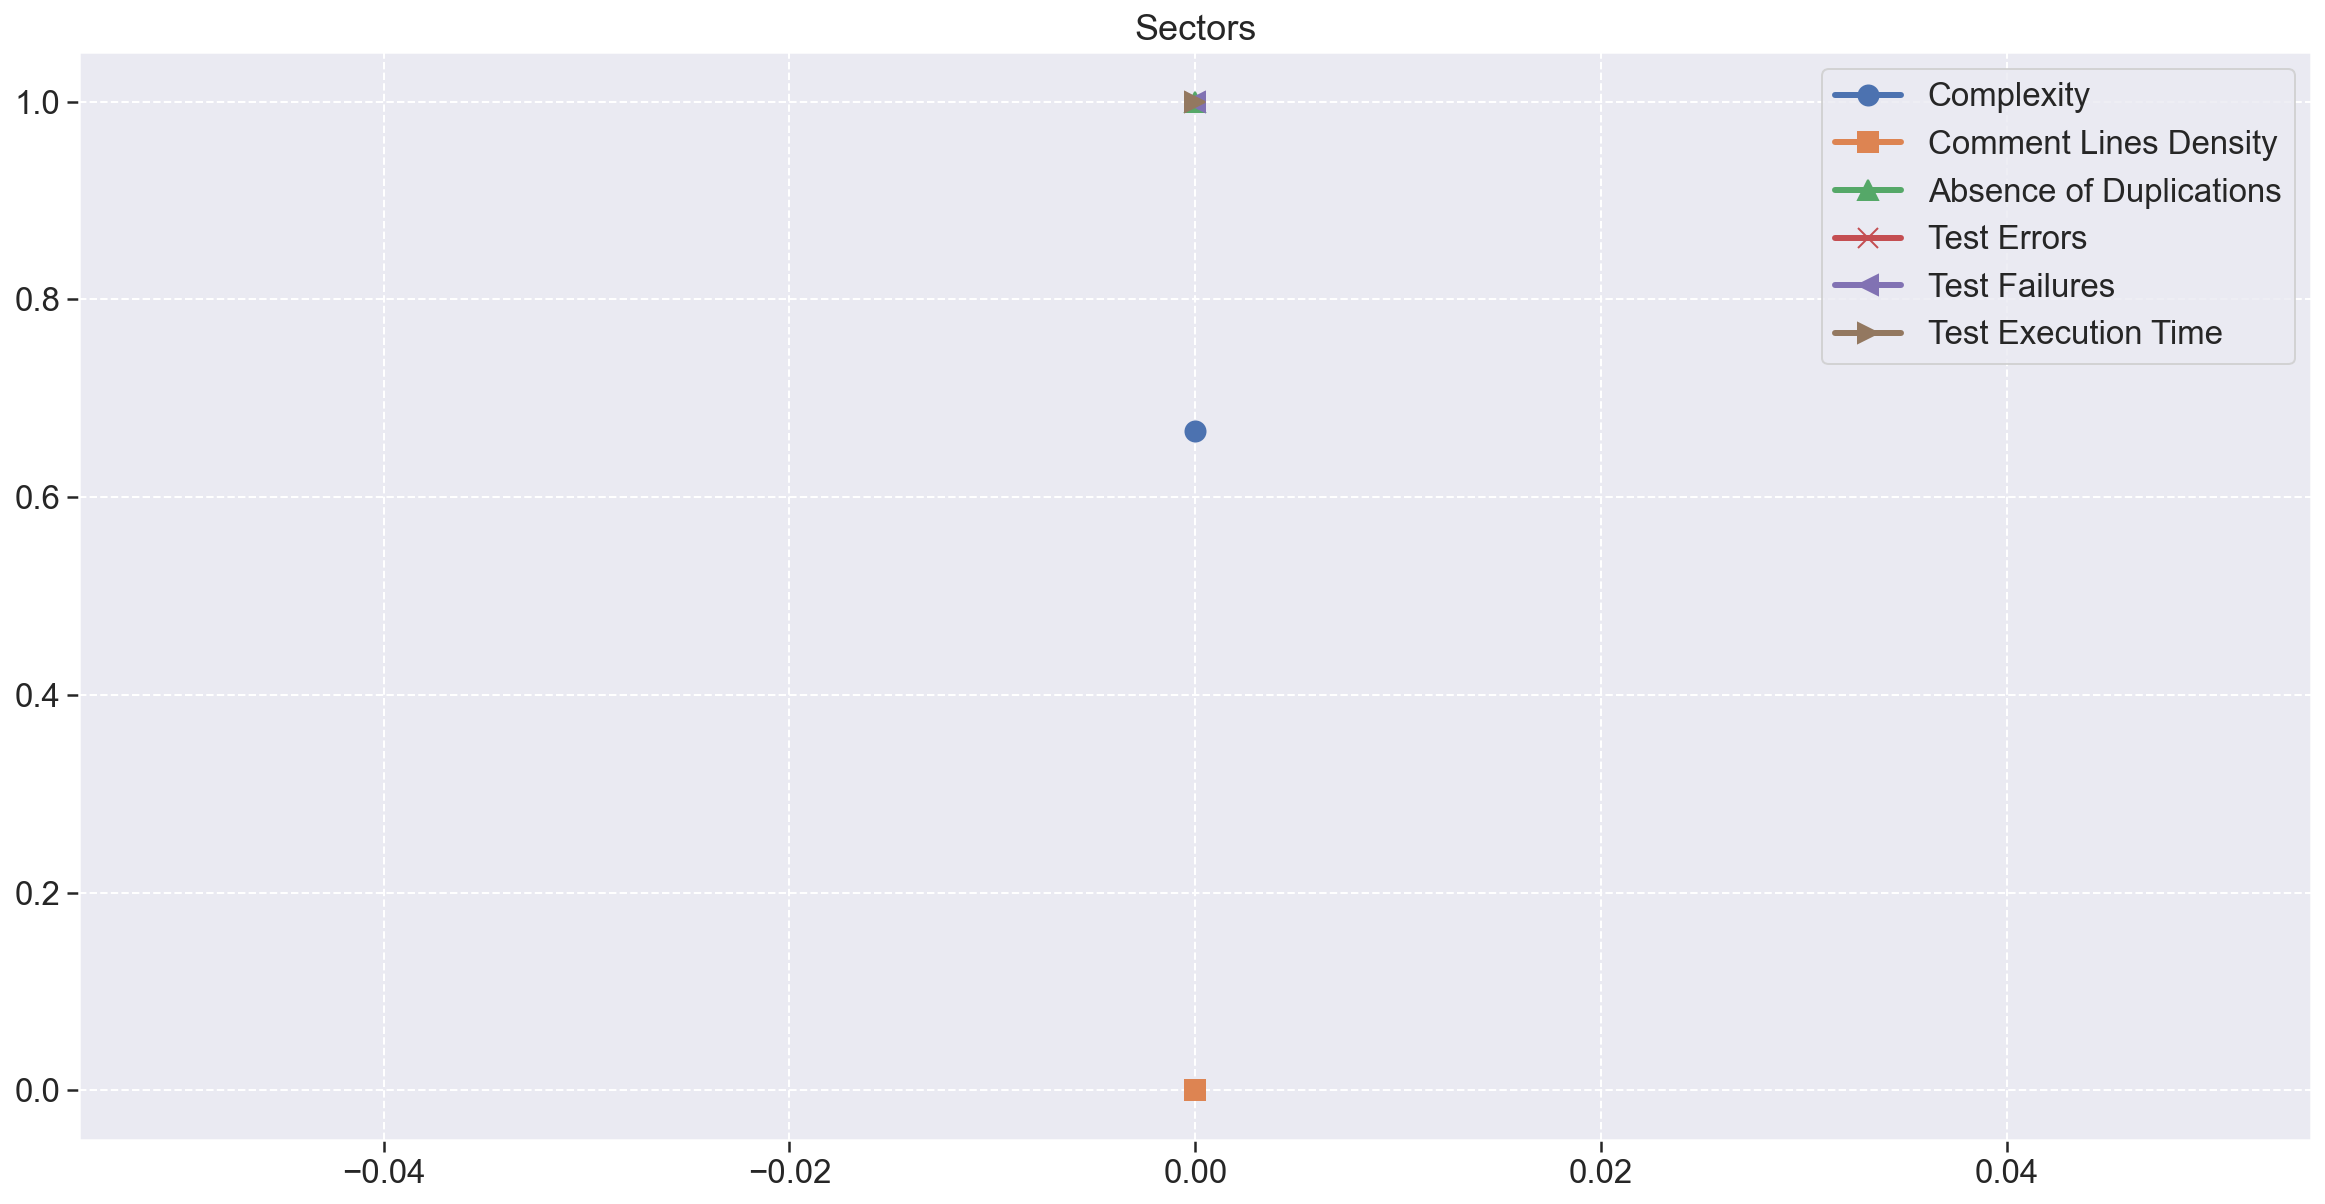

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.title('Sectors')
plt.plot(repo5_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo5_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo5_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo5_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo5_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo5_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

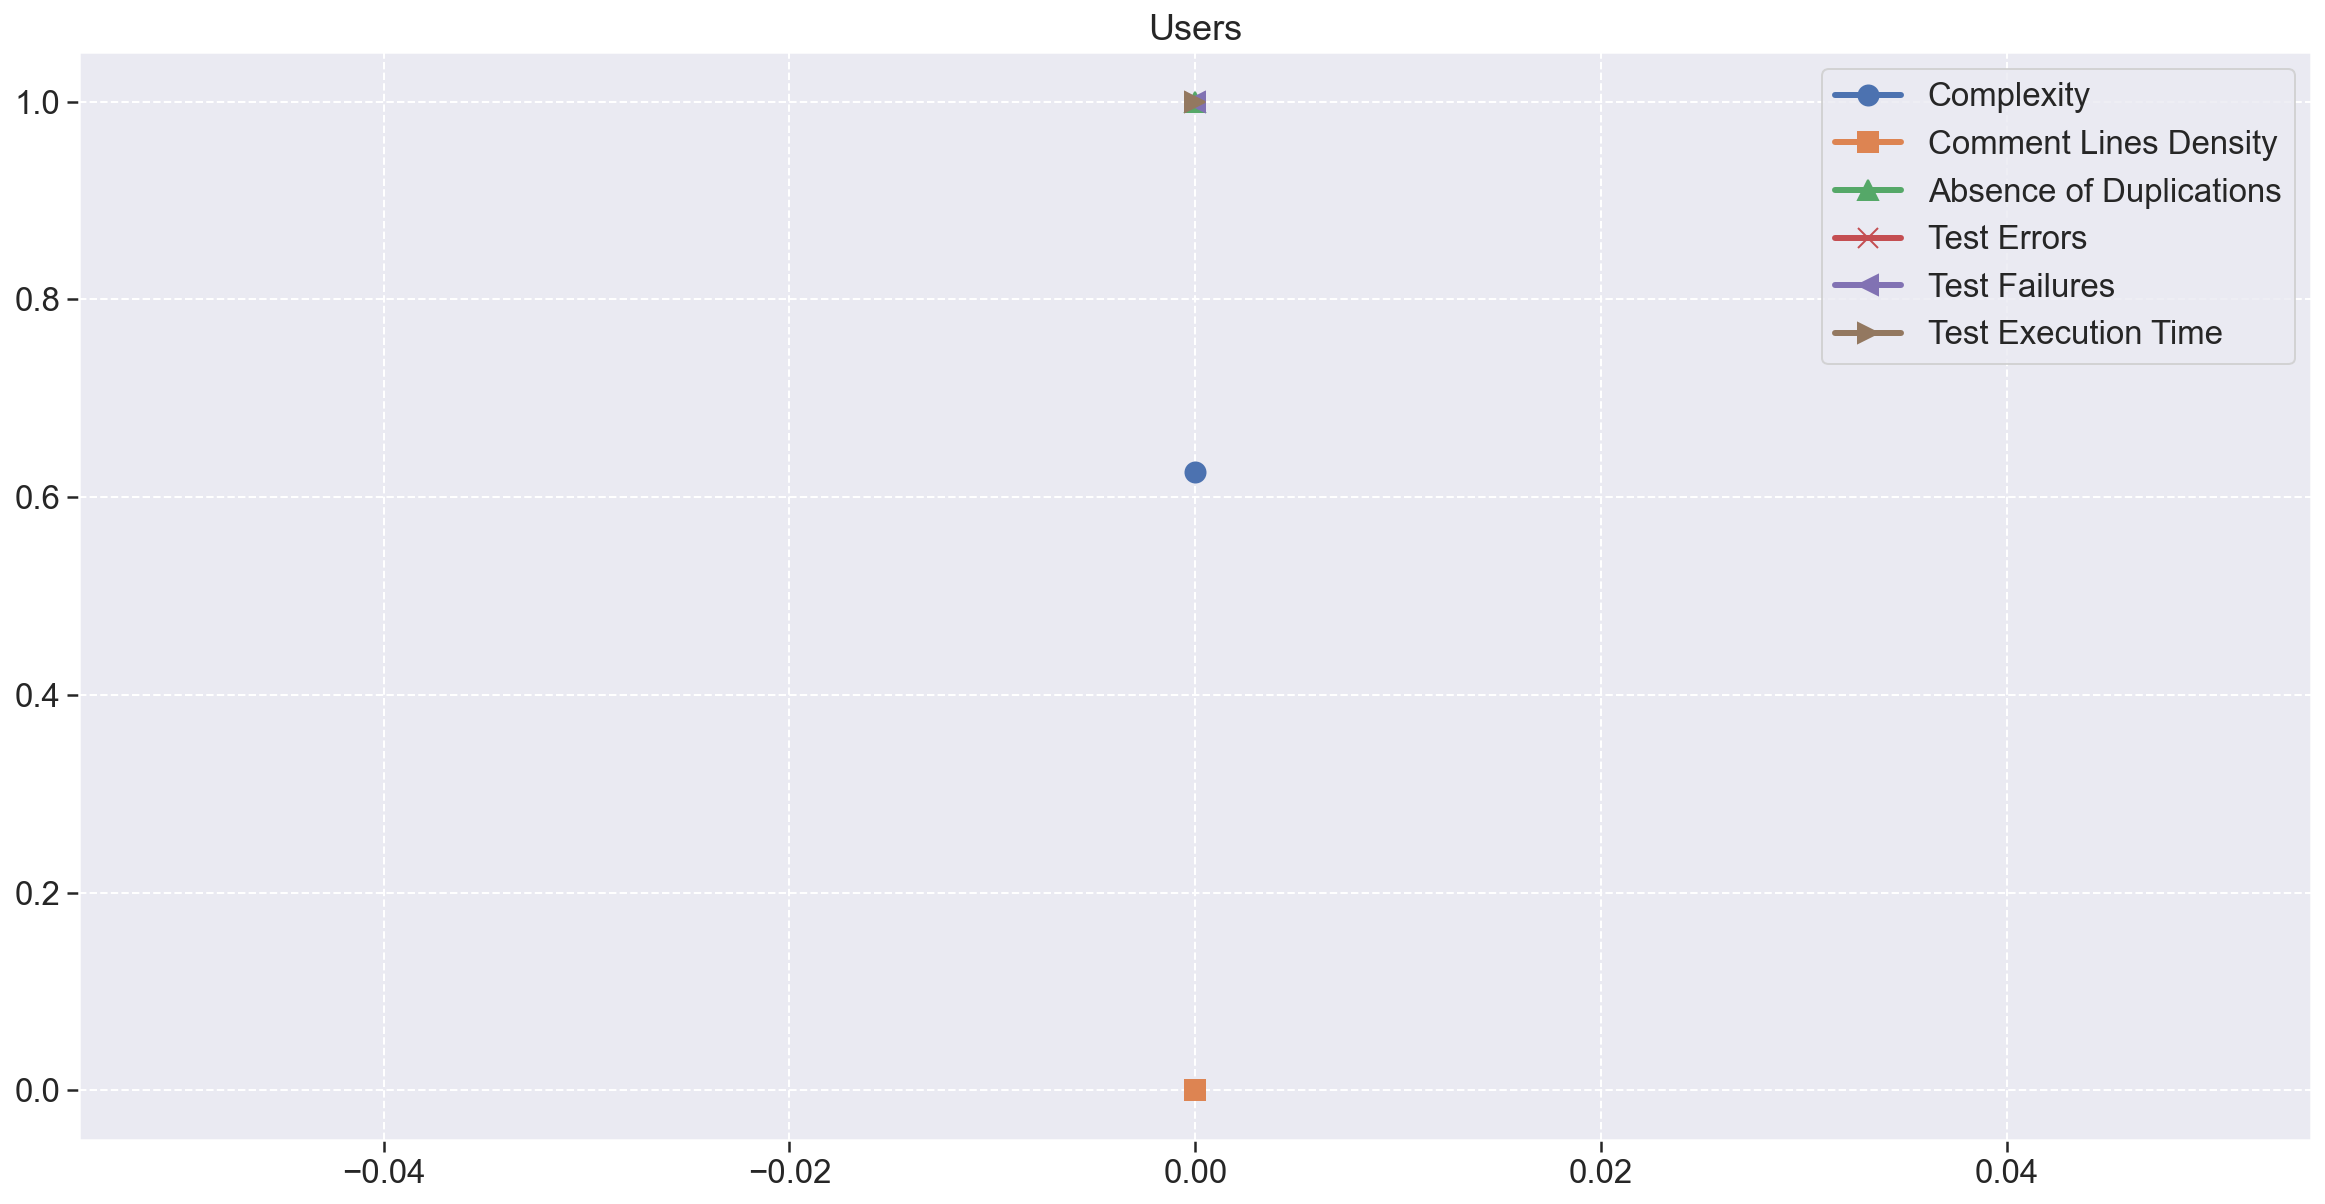

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.title('Users')
plt.plot(repo6_metrics['m1'], linewidth=3, marker='o', label='Complexity', markersize=10)
plt.plot(repo6_metrics['m2'], linewidth=3, marker='s', label='Comment Lines Density', markersize=10)
plt.plot(repo6_metrics['m3'], linewidth=3, marker='^', label='Absence of Duplications', markersize=10)
plt.plot(repo6_metrics['m4'], linewidth=3, marker='x', label='Test Errors', markersize=10)
plt.plot(repo6_metrics['m5'], linewidth=3, marker='<', label='Test Failures', markersize=10)
plt.plot(repo6_metrics['m6'], linewidth=3, marker='>', label='Test Execution Time', markersize=10)
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [48]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

repo1_metrics['code_quality'] = ((repo1_metrics['m1']*pm1) + (repo1_metrics['m2']*pm2) + (repo1_metrics['m3']*pm3)) * psc1
repo2_metrics['code_quality'] = ((repo2_metrics['m1']*pm1) + (repo2_metrics['m2']*pm2) + (repo2_metrics['m3']*pm3)) * psc1
repo3_metrics['code_quality'] = ((repo3_metrics['m1']*pm1) + (repo3_metrics['m2']*pm2) + (repo3_metrics['m3']*pm3)) * psc1
repo4_metrics['code_quality'] = ((repo4_metrics['m1']*pm1) + (repo4_metrics['m2']*pm2) + (repo4_metrics['m3']*pm3)) * psc1
repo5_metrics['code_quality'] = ((repo5_metrics['m1']*pm1) + (repo5_metrics['m2']*pm2) + (repo5_metrics['m3']*pm3)) * psc1
repo6_metrics['code_quality'] = ((repo6_metrics['m1']*pm1) + (repo6_metrics['m2']*pm2) + (repo6_metrics['m3']*pm3)) * psc1

repo1_metrics['testing_status'] = ((repo1_metrics['m4']*pm4) + (repo1_metrics['m5']*pm5) + (repo1_metrics['m6']*pm6)) * psc2
repo2_metrics['testing_status'] = ((repo2_metrics['m4']*pm4) + (repo2_metrics['m5']*pm5) + (repo2_metrics['m6']*pm6)) * psc2
repo3_metrics['testing_status'] = ((repo3_metrics['m4']*pm4) + (repo3_metrics['m5']*pm5) + (repo3_metrics['m6']*pm6)) * psc2
repo4_metrics['testing_status'] = ((repo4_metrics['m4']*pm4) + (repo4_metrics['m5']*pm5) + (repo4_metrics['m6']*pm6)) * psc2
repo5_metrics['testing_status'] = ((repo5_metrics['m4']*pm4) + (repo5_metrics['m5']*pm5) + (repo5_metrics['m6']*pm6)) * psc2
repo6_metrics['testing_status'] = ((repo6_metrics['m4']*pm4) + (repo6_metrics['m5']*pm5) + (repo6_metrics['m6']*pm6)) * psc2

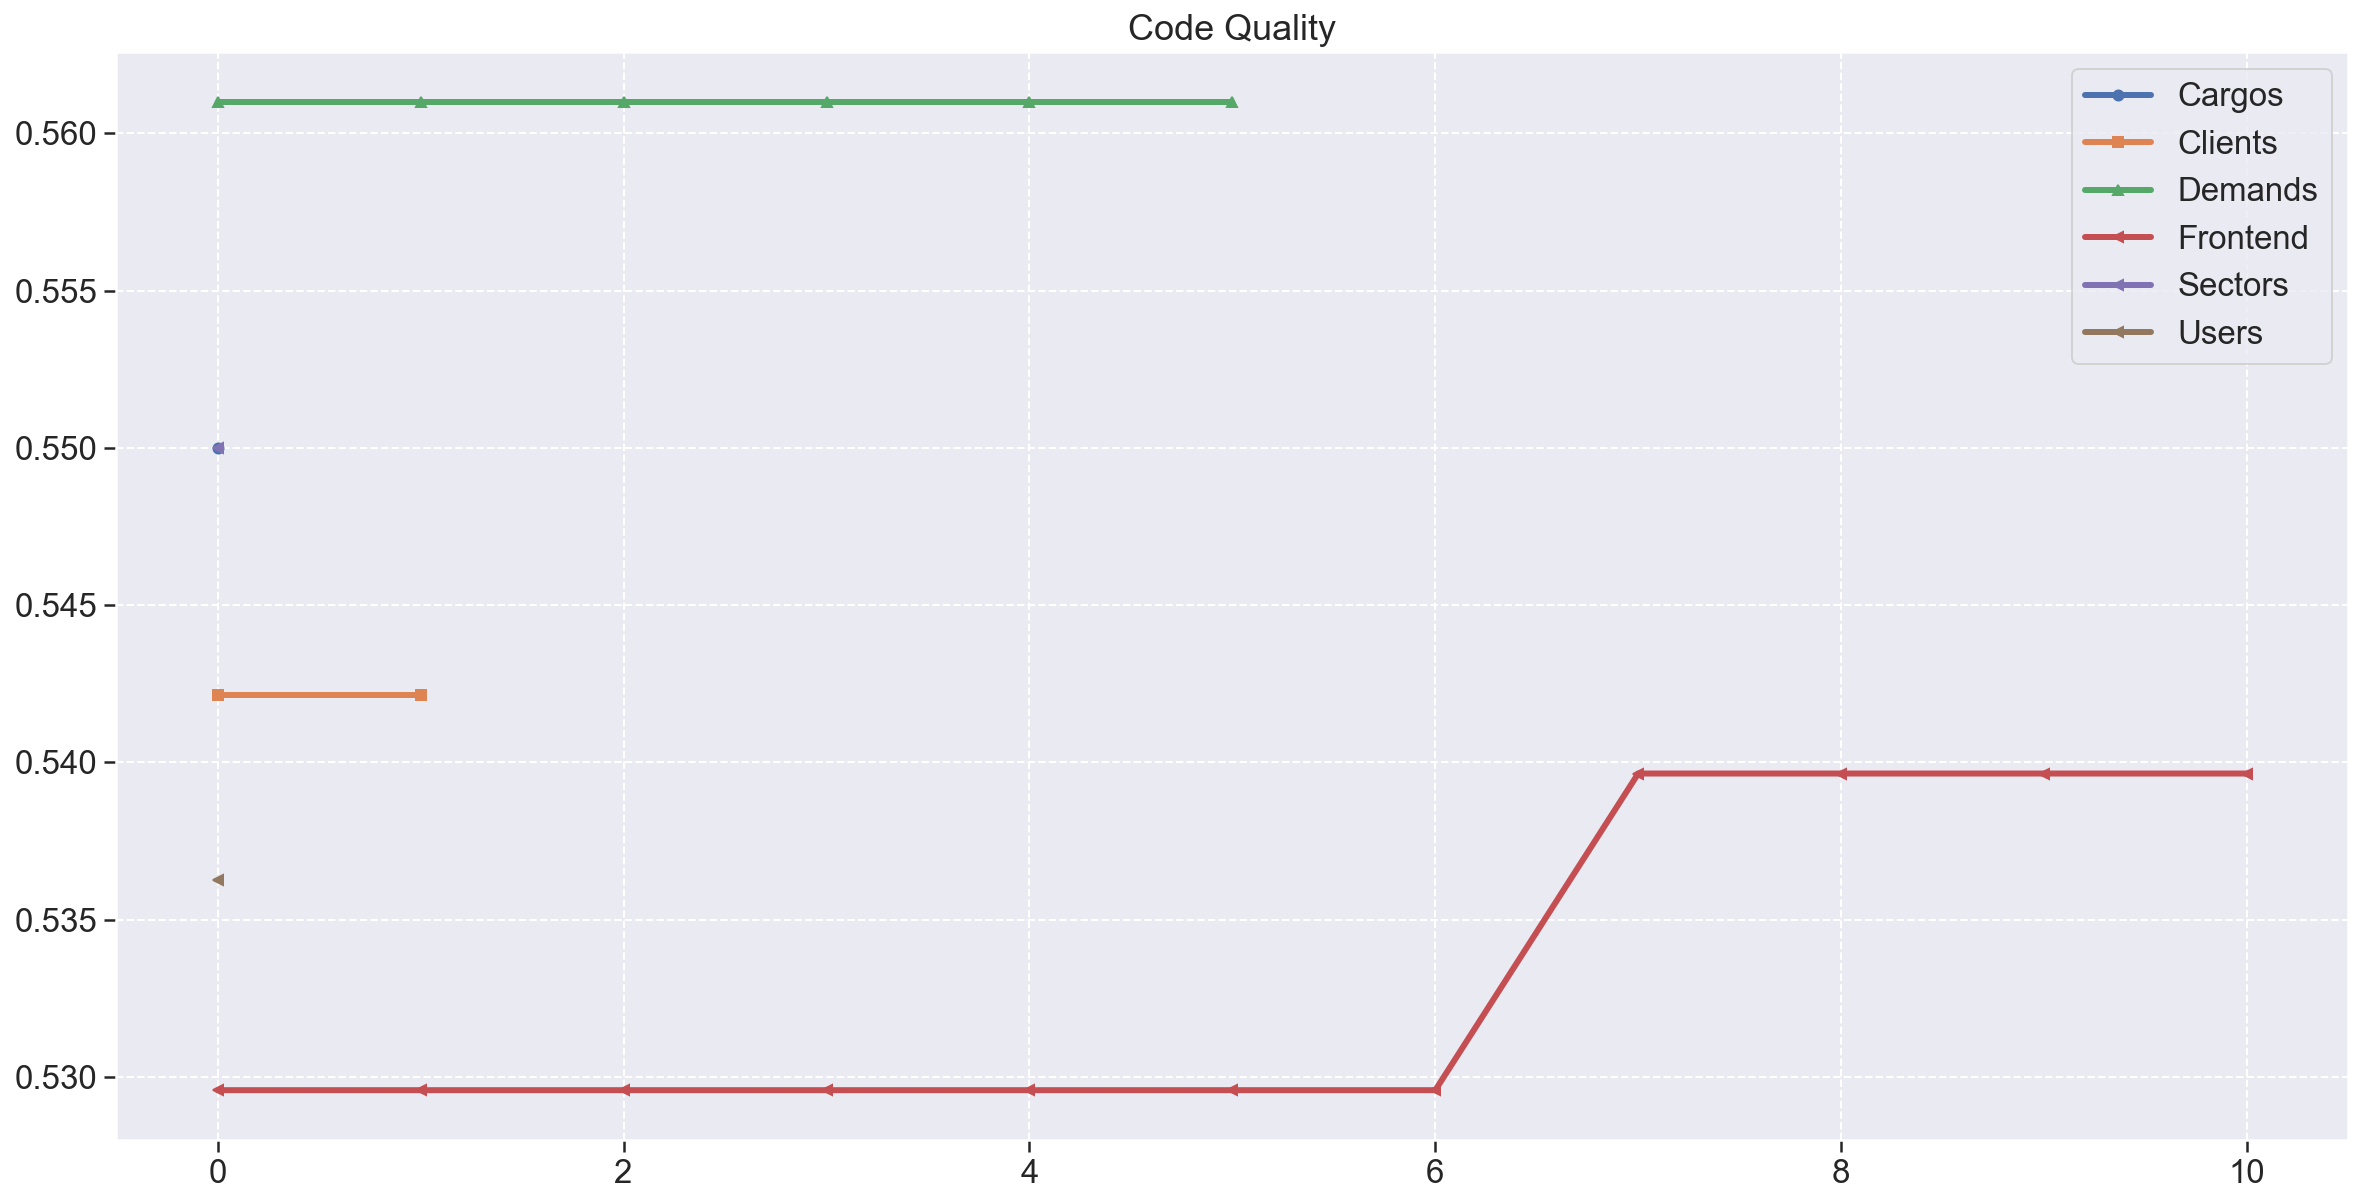

In [49]:
fig = plt.figure(figsize=(20, 10))

plt.title('Code Quality')
plt.plot(repo1_metrics['code_quality'], linewidth=3, marker='o', label='Cargos', markersize=5)
plt.plot(repo2_metrics['code_quality'], linewidth=3, marker='s', label='Clients', markersize=5)
plt.plot(repo3_metrics['code_quality'], linewidth=3, marker='^', label='Demands', markersize=5)
plt.plot(repo4_metrics['code_quality'], linewidth=3, marker='<', label='Frontend', markersize=5)
plt.plot(repo5_metrics['code_quality'], linewidth=3, marker='<', label='Sectors', markersize=5)
plt.plot(repo6_metrics['code_quality'], linewidth=3, marker='<', label='Users', markersize=5)
plt.legend()

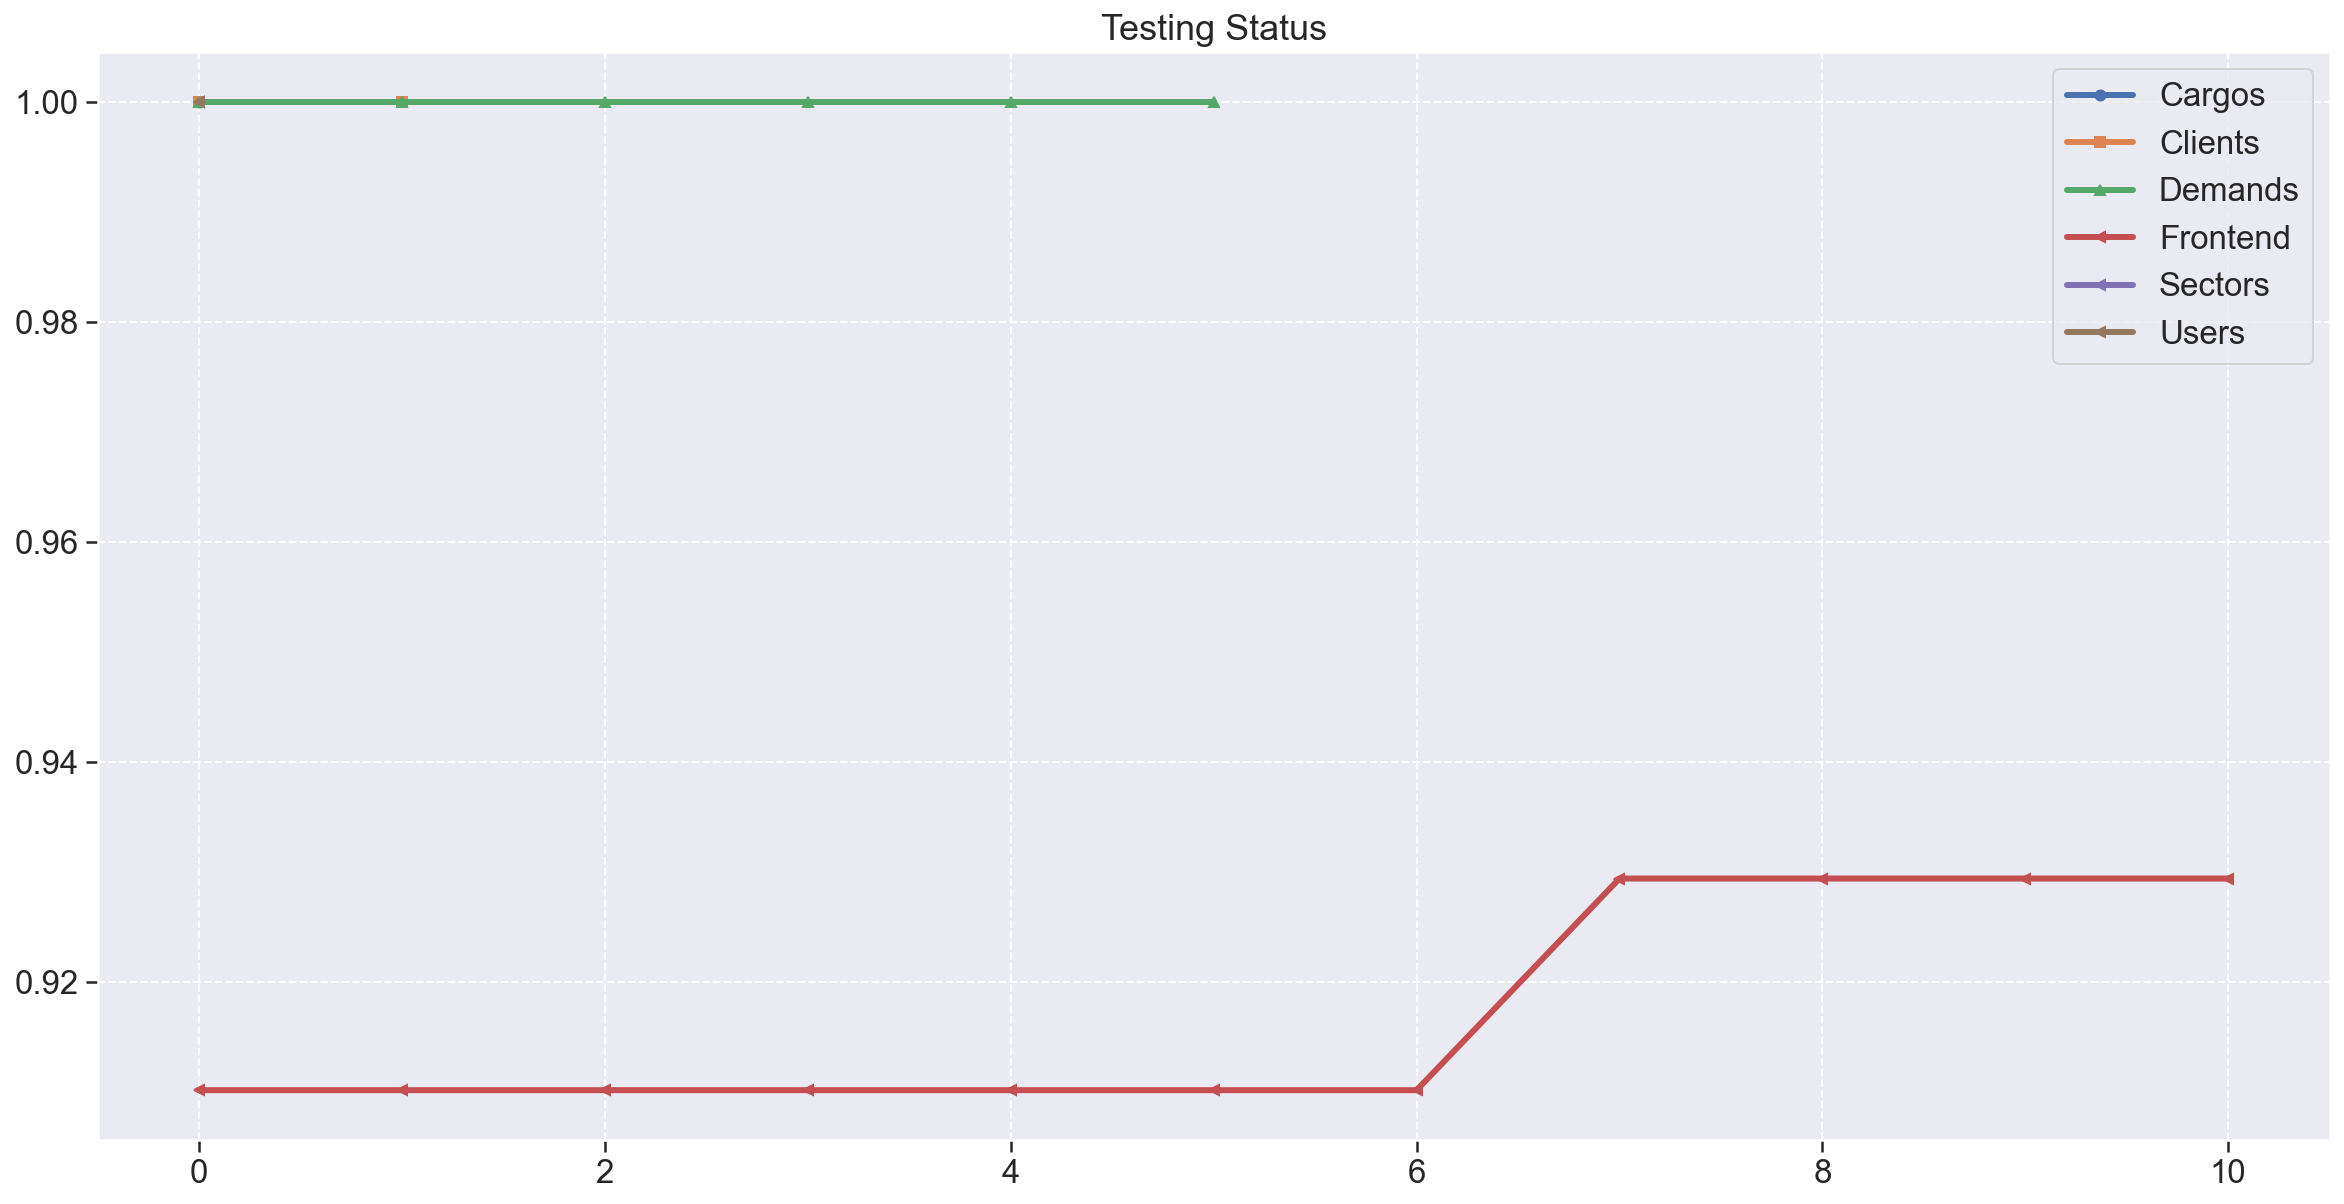

In [50]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(repo1_metrics['testing_status'], linewidth=3, marker='o', label='Cargos', markersize=5)
plt.plot(repo2_metrics['testing_status'], linewidth=3, marker='s', label='Clients', markersize=5)
plt.plot(repo3_metrics['testing_status'], linewidth=3, marker='^', label='Demands', markersize=5)
plt.plot(repo4_metrics['testing_status'], linewidth=3, marker='<', label='Frontend', markersize=5)
plt.plot(repo5_metrics['testing_status'], linewidth=3, marker='<', label='Sectors', markersize=5)
plt.plot(repo6_metrics['testing_status'], linewidth=3, marker='<', label='Users', markersize=5)
plt.legend()

In [54]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, repo3_metrics, repo4_metrics, repo5_metrics, repo6_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['reliability']

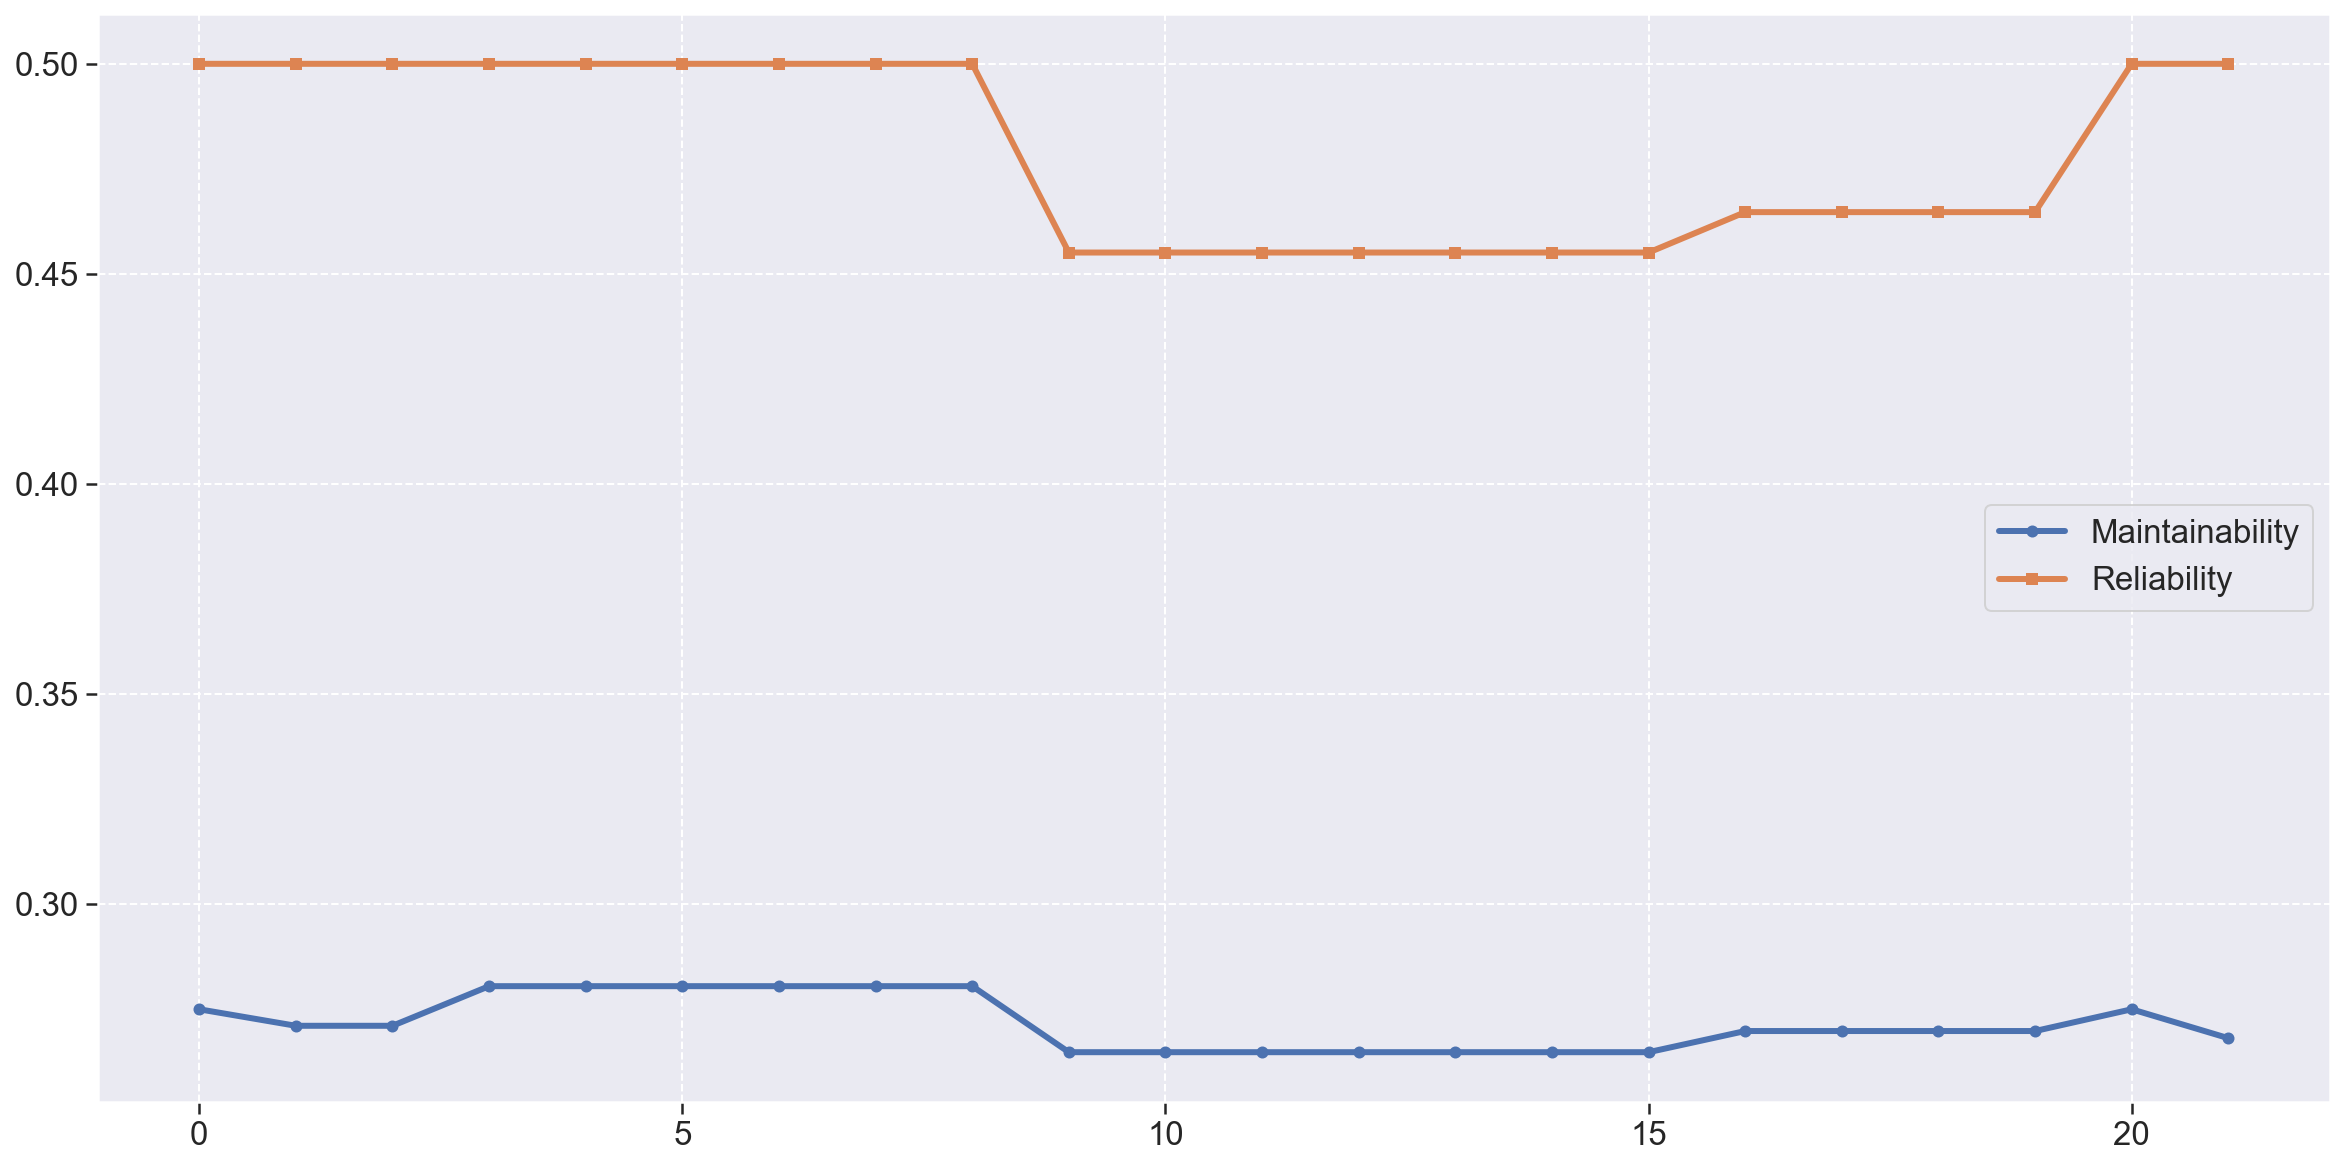

In [57]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', label='Maintainability', markersize=5)
plt.plot(metrics_df['reliability'], linewidth=3, marker='s', label='Reliability', markersize=5)
plt.legend()

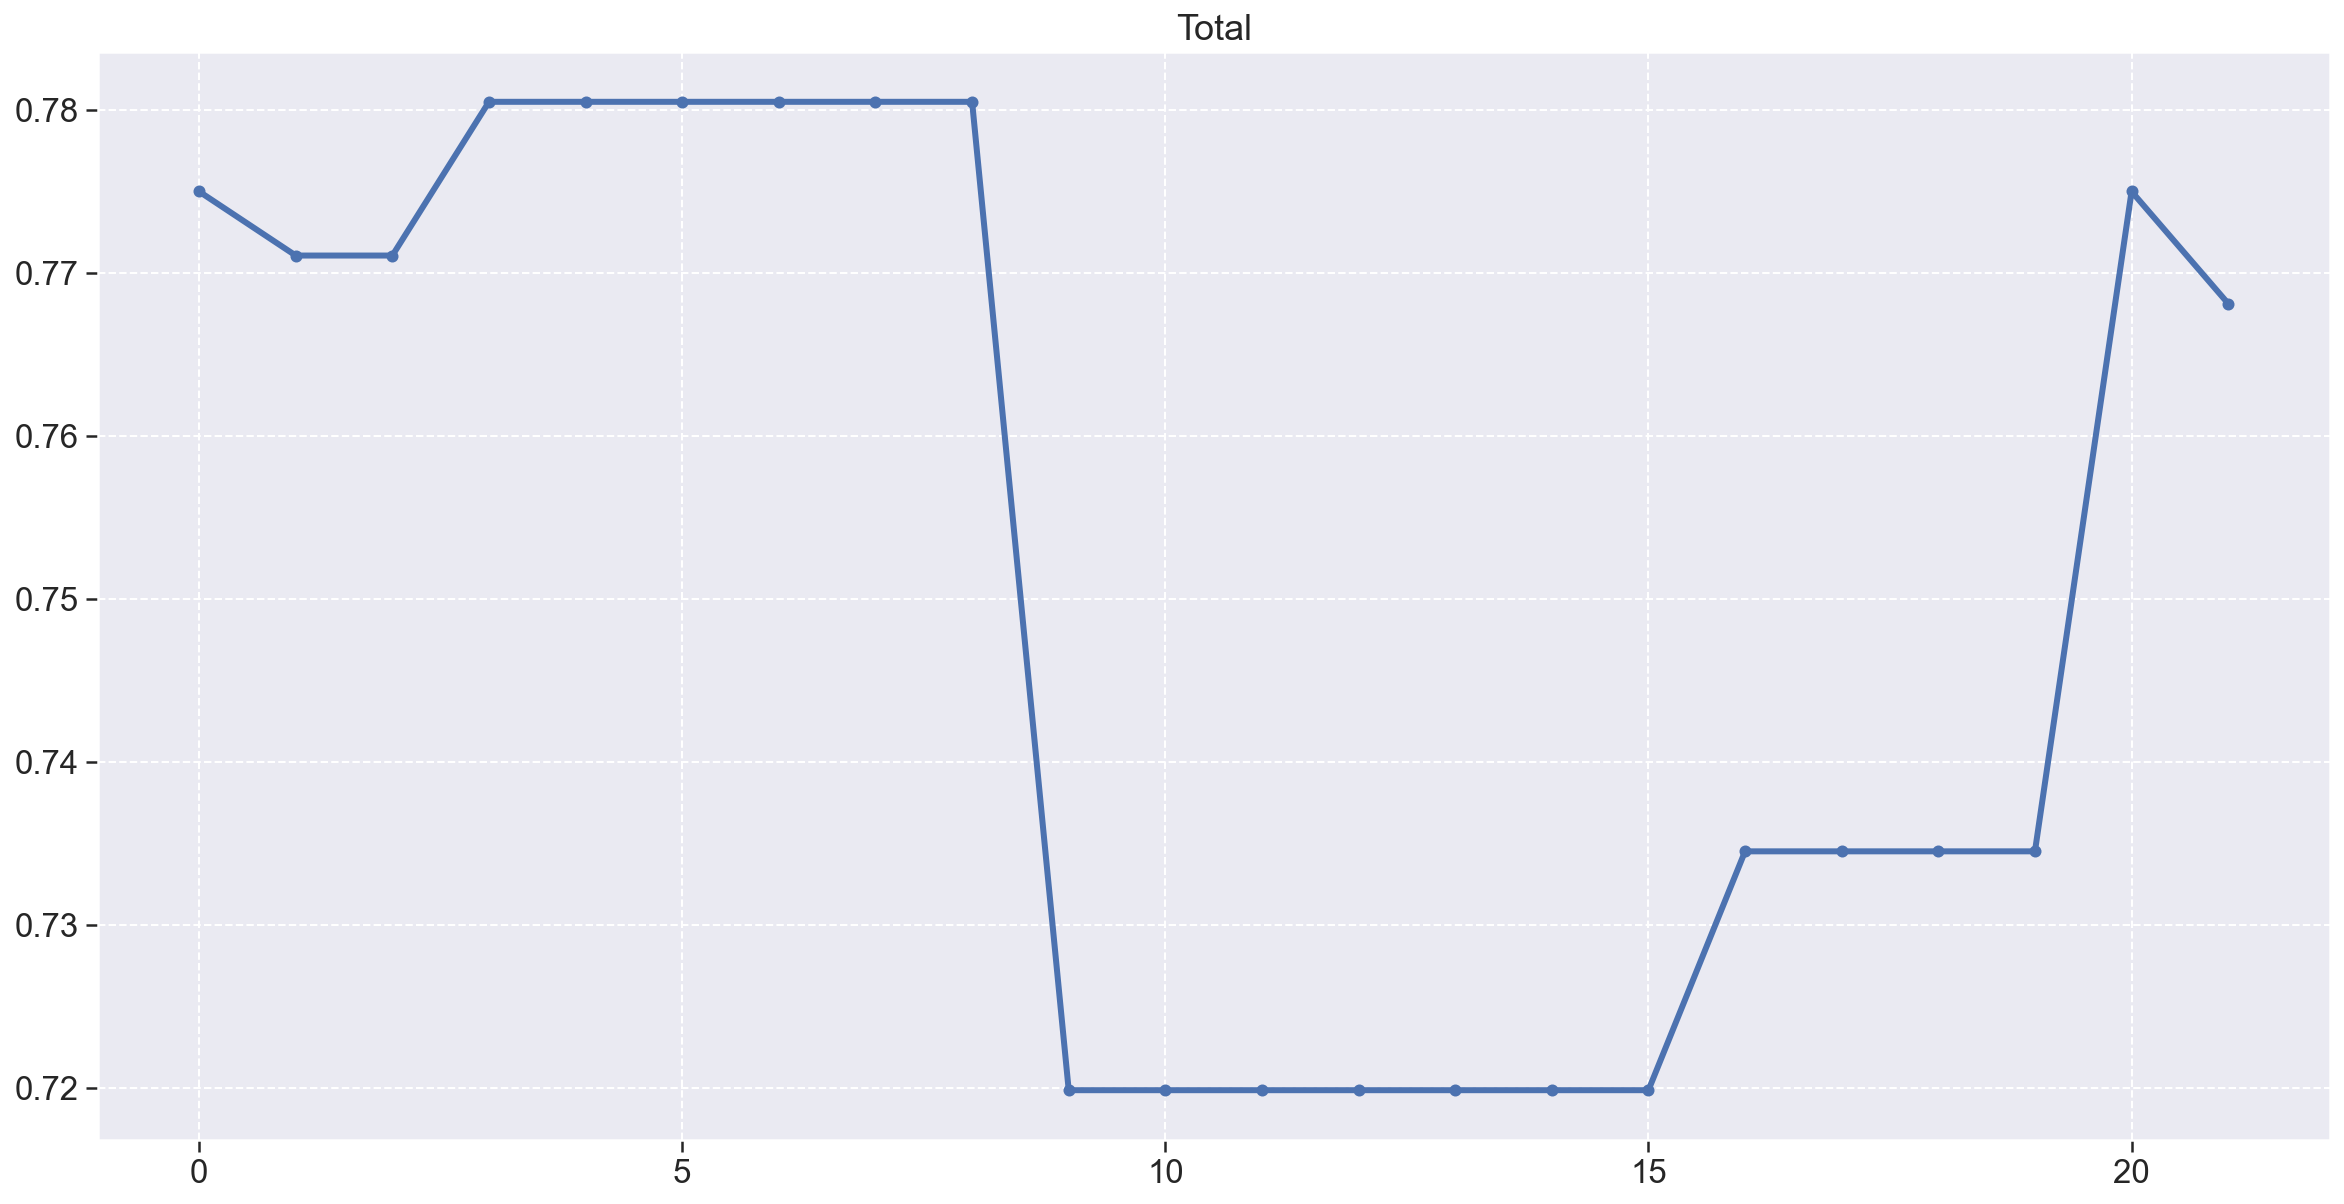

In [59]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


In [61]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_csv('fga-eps-mds-2021_2_SiGeD-DATASET-{}.csv'.format(currentDateTime), index = False)